# Drexel University
## College of Computing and Informatics
## INFO 323: Cloud Computing and Big Data
### Assignment 2 Exploratory Data Analysis Using BigQuery on GCP
### Due Date: Sunday, April 27, 2025
This question counts for 10% of the final grade.


### A. Assignment 2 Overview
This question provides the opportunity for you to practice big data analytics using BigQuery on GCP.

### B. What to Hand In

Sumbit a completed this Jupyter notebook and the required results.

### C. What to do
1. Create an instance on GCP’s Vertex AI workbench.
3. Upload the given notebook “INFO323-assign2-BigQuery.ipynb” to your bucket in GCP Storage.
3. Open the notebook from the instance Jupyter Notebook.
4. Answer the questions in the notebook using the data in the BigQuery platform.
5. Download the notebook from the bucket.
6. Submit the completed Jupyter notebook.


# YOUR NAME:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery

In [2]:
bq = bigquery.Client()

## Data Ingest:
- You should have downloaded and ingested the flight data of the year 2018 to BigQuery
- For this assignment, you also need to ingested the flight data of the year 2019 to BigQuery for evaluting your models.

## Know the Data
- The on-performance flight data has 111 attributes. To find the names and meanings of the attributes, you can look at the columns of the table at the BigQuery console or at the BTS Website: https://transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ

## Use the BigQuery Platform
- You should mainly use the BigQuery platform to explore and analyze the data ingested in BigQuery.
- Visualization can be done by related Python packages.

### Question 1:
Plot the distribution of the arrival delays in 2018. Describe the key summary statistics of the arrival delays.

In [12]:
query_2018 = """
SELECT ArrDelay
FROM `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE ArrDelay IS NOT NULL
"""
arrival_delays = bq.query(query_2018).to_dataframe()
arrival_delays

,ArrDelay
0,58.0
1,348.0
2,29.0
3,29.0
4,26.0
...,...
6446486,20.0
6446487,20.0
6446488,20.0
6446489,20.0


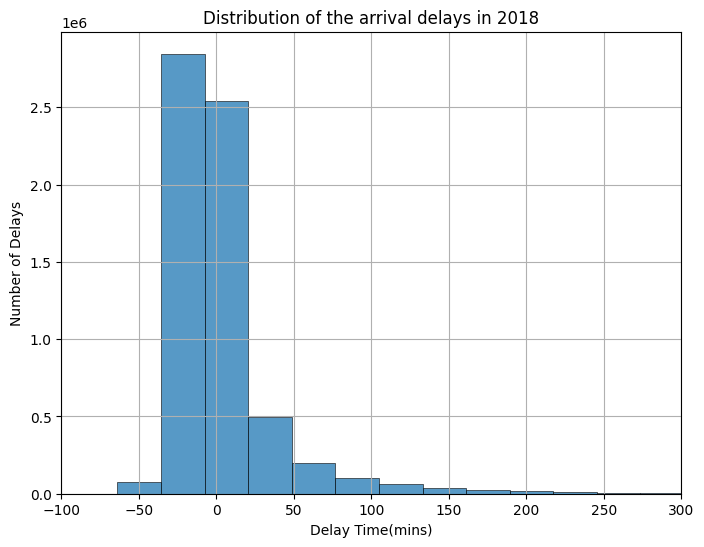

In [6]:
plt.figure(figsize=(8,6))
sns.histplot(arrival_delays['ArrDelay'], bins=100)
plt.title('Distribution of the arrival delays in 2018')
plt.xlabel('Delay Time(mins)')
plt.ylabel('Number of Delays')
plt.grid(True)
plt.xlim(-100,300) #zooms in the visual to get arrival delay time from -100 to 300 mins
plt.show()

In [10]:
arrival_delays['ArrDelay'].describe()

count    6.446491e+06
mean     4.591343e+00
std      4.628048e+01
min     -1.200000e+02
25%     -1.400000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.692000e+03
Name: ArrDelay, dtype: float64

Mean delay: About +5 minutes, so flights arrived slightly late on average.

Median delay: About -6 minutes, meaning more than half arrived early or on time.

Spread: High variability (std ≈ 46 minutes).

Range: From -120 minutes (early) to +2692 minutes (very late).

Shape: Right-skewed.

### Question 2:
For each origin airport, find the average departure and arrival delays in 2018. For the airports that have at least 1 flight per day, plot the average departure delays and average arrival delays. List the top 10 airports that have the largest average arrival delays for flights at destinations.

In [17]:
query_avg_delays = """
SELECT 
    Origin AS airport, AVG(ArrDelay) AS avg_arr_delay, AVG(DepDelay) AS avg_dep_delay, COUNT(*) AS flight_count
FROM
    `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE 
    ArrDelay IS NOT NULL
GROUP BY
    ORIGIN
"""

airport_avg_delays = bq.query(query_avg_delays).to_dataframe()
airport_avg_delays

,airport,avg_arr_delay,avg_dep_delay,flight_count
0,MYR,4.617797,8.428310,9822
1,ORD,9.476481,11.570874,295380
2,LAX,1.057152,8.085911,199381
3,EWR,7.817558,13.791898,127016
4,BRW,-8.349158,-7.437979,653
...,...,...,...,...
353,CGI,9.350000,6.044444,540
354,YUM,-5.326466,-0.232171,1262
355,DRT,-9.805310,6.725664,113
356,HYA,29.327586,38.431034,58


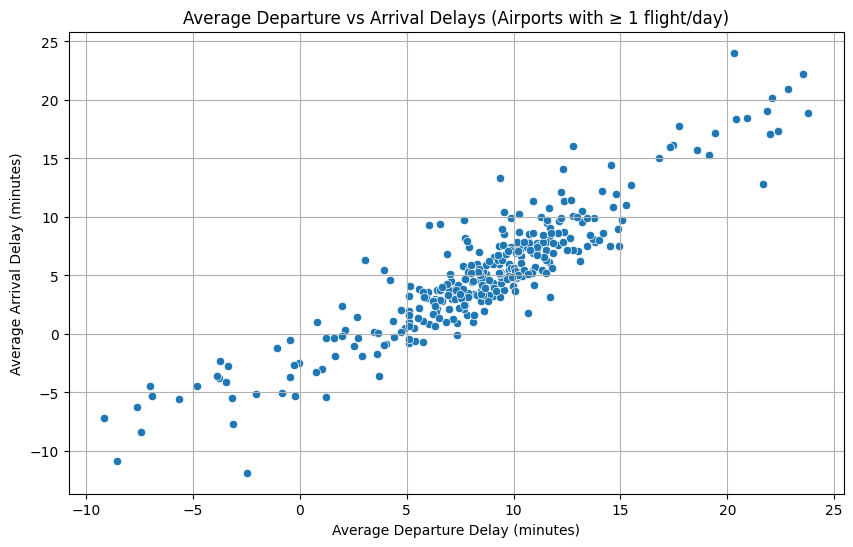

In [18]:
airport_avg_delays_filtered = airport_avg_delays[airport_avg_delays['flight_count'] >= 365]
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=airport_avg_delays_filtered,
    x='avg_dep_delay',
    y='avg_arr_delay'
)
plt.title('Average Departure vs Arrival Delays (Airports with ≥ 1 flight/day)')
plt.xlabel('Average Departure Delay (minutes)')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

In [19]:
top10_airports_arrival = airport_avg_delays_filtered.sort_values(
    by='avg_arr_delay', ascending=False
).head(10)
print(top10_airports_arrival)

    airport  avg_arr_delay  avg_dep_delay  flight_count
19      SLN      24.037225      20.324873           591
259     SCK      22.177347      23.526080           671
228     CMX      20.939587      22.837838           629
223     LWB      20.127049      22.102459           488
339     BLV      19.038961      21.870130           924
261     TTN      18.915530      23.789265          2273
267     ORH      18.428743      20.898204           835
100     LCK      18.336766      20.403708           971
57      USA      17.734994      17.723669           883
342     ACK      17.383667      22.354938           649


## For the rest of the questions, you should only focus on the airports that have at least 1 flight per day.

### Question 3:
What is the percentage of the delayed flights in 2018?

In [20]:
# Get list of airports with at least 365 flights
valid_airports = airport_avg_delays_filtered['airport'].tolist()

In [24]:
# Format airports into a string for SQL. This is needed so that SQL doesn't show an invalid syntax error, since SQL doesn't take in a list.
#(Just turning a list into a string to make it SQL-compatible)
airport_list = ','.join([f"'{airport}'" for airport in valid_airports])

query_delays = f"""
SELECT
  COUNT(*) AS total_flights,
  SUM(CASE WHEN ArrDelay > 0 THEN 1 ELSE 0 END) AS delayed_flights
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  ORIGIN IN ({airport_list})
  AND ArrDelay IS NOT NULL
"""

delay_stats = bq.query(query_delays).to_dataframe()
delay_stats

,total_flights,delayed_flights
0,6441859,2269129


In [23]:
total_flights = delay_stats['total_flights'][0]
delayed_flights = delay_stats['delayed_flights'][0]

delay_percentage = (delayed_flights / total_flights) * 100

print(f"Percentage of delayed flights: {delay_percentage:.2f}%")

Percentage of delayed flights: 35.22%


### Question 4:
Which are the top 5 origin airports that have the highest percentage of delayed flights in 2018? List the origin airports with more than 30% of delayed flights.

In [39]:
#same sql code as above but just adding the origin column:
#the f"""  is required if you are referenceing a python variable in your sql code
query_delayed_percentages = f""" 
SELECT
  ORIGIN AS airport,
  COUNT(*) AS total_flights,
  SUM(CASE WHEN ArrDelay > 0 THEN 1 ELSE 0 END) AS delayed_flights
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  ORIGIN IN ({airport_list})
  AND ArrDelay IS NOT NULL
GROUP BY
  ORIGIN
"""

airport_delay_stats = bq.query(query_delayed_percentages).to_dataframe()

airport_delay_stats 

,airport,total_flights,delayed_flights
0,JFK,114478,38080
1,MDW,77255,34655
2,ADQ,562,134
3,JNU,3861,940
4,OTZ,625,176
...,...,...,...
322,ROW,1220,322
323,APN,546,183
324,USA,883,418
325,RHI,649,172


In [30]:
#adding the percentage col
airport_delay_stats['delay_percentage'] = (airport_delay_stats['delayed_flights'] / airport_delay_stats['total_flights']) * 100
airport_delay_stats

,airport,total_flights,delayed_flights,delay_percentage
0,CLT,206325,85210,41.298922
1,PGD,4816,1576,32.724252
2,DFW,248462,103217,41.542369
3,AUS,56880,20367,35.806962
4,BWI,95237,33683,35.367557
...,...,...,...,...
322,BLI,2062,587,28.467507
323,LSE,1875,562,29.973333
324,IAG,731,304,41.586867
325,CMX,629,212,33.704293


In [31]:
#The top 5 origin airports that have the highest percentage of delayed flights in 2018
top5_delayed_airports = airport_delay_stats.sort_values(
    by='delay_percentage', ascending=False
).head(5)

print(top5_delayed_airports[['airport', 'delay_percentage']])

    airport  delay_percentage
28      SCK         63.636364
209     SLN         47.715736
246     USA         47.338618
84      BLV         46.969697
36      ORH         46.467066


In [35]:
#Origin airports with more than 30% of delayed flights
airports_above_30pct = airport_delay_stats[airport_delay_stats['delay_percentage'] > 30]

print(airports_above_30pct[['airport', 'delay_percentage']])

    airport  delay_percentage
0       CLT         41.298922
1       PGD         32.724252
2       DFW         41.542369
3       AUS         35.806962
4       BWI         35.367557
..      ...               ...
318     MBS         30.772262
319     BQN         39.230327
320     LWB         42.622951
324     IAG         41.586867
325     CMX         33.704293

[230 rows x 2 columns]


### Question 5:
Which are the top 5 pairs of origin and destination airports that have the highest percentage of delayed flights in 2018? List the pairs of origin and destination airports with more than 30% of delayed flights.

In [40]:
query_od_delayed_percentages = f"""
SELECT
  ORIGIN AS origin_airport,
  DEST AS destination_airport,
  COUNT(*) AS total_flights,
  SUM(CASE WHEN ArrDelay > 0 THEN 1 ELSE 0 END) AS delayed_flights
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  ORIGIN IN ({airport_list})
  AND DEST IN ({airport_list})
  AND ArrDelay IS NOT NULL
GROUP BY
  ORIGIN, DEST
"""

od_delay_stats = bq.query(query_od_delayed_percentages).to_dataframe()

In [43]:
#adding the percentage col
od_delay_stats['delay_percentage'] = (od_delay_stats['delayed_flights'] / od_delay_stats['total_flights']) * 100
#sorting and getting top5
top5_od_delayed = od_delay_stats.sort_values(
    by='delay_percentage', ascending=False
).head(5)

print(top5_od_delayed[['origin_airport', 'destination_airport', 'delay_percentage']])

     origin_airport destination_airport  delay_percentage
6202            PVU                 OAK             100.0
6201            DAL                 GSP             100.0
4261            IAH                 JFK             100.0
605             AVP                 PIE             100.0
1814            SFO                 SDF             100.0


In [44]:
# Origin-destination pairs with >30% delayed flights
od_above_30pct = od_delay_stats[od_delay_stats['delay_percentage'] > 30]

print(od_above_30pct[['origin_airport', 'destination_airport', 'delay_percentage']])

     origin_airport destination_airport  delay_percentage
1               LAX                 ABQ         36.197917
8               BWI                 ALB         35.861258
10              PHX                 AMA         40.585774
11              HNL                 ANC         34.242424
14              CRW                 ATL         35.669674
...             ...                 ...               ...
6195            ATL                 MSO         66.666667
6196            CMH                 PBI         42.857143
6197            HTS                 PGD              50.0
6201            DAL                 GSP             100.0
6202            PVU                 OAK             100.0

[4468 rows x 3 columns]


### Question 6:
Which are the top 5 airlines that have the highest percentage of delayed flights in 2018? List the airlines with more than 30% of delayed flights.

In [51]:
query_airline_delays = """
SELECT
  Reporting_Airline AS airline,
  COUNT(*) AS total_flights,
  SUM(CASE WHEN ArrDelay > 0 THEN 1 ELSE 0 END) AS delayed_flights
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  ArrDelay IS NOT NULL
GROUP BY
  Reporting_Airline
"""
airline_delay_stats = bq.query(query_airline_delays).to_dataframe()

In [52]:
# Adding the delay percentage column
airline_delay_stats['delay_percentage'] = (airline_delay_stats['delayed_flights'] / airline_delay_stats['total_flights']) * 100
# Sorting and getting top 5 airlines
top5_airlines_delayed = airline_delay_stats.sort_values(
    by='delay_percentage', ascending=False
).head(5)

print(top5_airlines_delayed[['airline', 'delay_percentage']])

   airline  delay_percentage
14      F9          43.83742
10      B6         42.430929
11      OH          40.11164
7       G4         39.084038
13      WN         38.516797


In [53]:
# Airlines with >30% delayed flights
airlines_above_30pct = airline_delay_stats[airline_delay_stats['delay_percentage'] > 30]

print(airlines_above_30pct[['airline', 'delay_percentage']])

   airline  delay_percentage
0       AS         33.875866
2       MQ         36.892148
3       EV         34.552448
4       UA         33.947766
5       AA         36.921549
6       NK         31.499043
7       G4         39.084038
8       VX         36.949805
9       YX         32.686322
10      B6         42.430929
11      OH          40.11164
12      OO         34.396174
13      WN         38.516797
14      F9          43.83742
15      YV         37.884173
16      9E         30.732143
17      HA           33.4924


### Question 7:
Will the percentages of delayed flights change for airlines at different origin and destination airports in 2018? List the combinations of airlines, origins, and destinations with more than 30% of delayed flights.

In [59]:
#same sql as above now agian just adding the origin
query_airline_od_delays = """
SELECT
  Reporting_Airline AS airline,
  ORIGIN AS origin_airport,
  DEST AS destination_airport,
  COUNT(*) AS total_flights,
  SUM(CASE WHEN ArrDelay > 0 THEN 1 ELSE 0 END) AS delayed_flights
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  ArrDelay IS NOT NULL
GROUP BY
  Reporting_Airline, ORIGIN, DEST
"""
airline_od_delay_stats = bq.query(query_airline_od_delays).to_dataframe()
# Adding the delay percentage column
airline_od_delay_stats['delay_percentage'] = (
    airline_od_delay_stats['delayed_flights'] / airline_od_delay_stats['total_flights']
) * 100
airline_od_delay_stats

,airline,origin_airport,destination_airport,total_flights,delayed_flights,delay_percentage
0,OO,ORD,ABE,145,61,42.068966
1,WN,DAL,ABQ,1523,707,46.421536
2,YV,DFW,ABQ,797,354,44.416562
3,OO,MSP,ABR,672,166,24.702381
4,MQ,DFW,ACT,1393,504,36.180905
...,...,...,...,...,...,...
12959,EV,GSO,ATL,2,1,50.0
12960,YX,ELP,OKC,1,1,100.0
12961,YX,PNS,ORD,1,1,100.0
12962,AA,DCA,MCI,1,1,100.0


Yes, the percentages of delayed flights do change significantly for airlines depending on the origin and destination airports.

In [58]:
# the combinations of airlines, origins, and destinations with more than 30% of delayed flights.
airline_od_above_30pct = airline_od_delay_stats[
    airline_od_delay_stats['delay_percentage'] > 30
]

# Show results
print(airline_od_above_30pct[['airline', 'origin_airport', 'destination_airport', 'delay_percentage']])

      airline origin_airport destination_airport  delay_percentage
0          OO            ORD                 ABE         42.068966
1          WN            DAL                 ABQ         46.421536
2          YV            DFW                 ABQ         44.416562
4          MQ            DFW                 ACT         36.180905
5          OO            ATL                 AEX         35.745297
...       ...            ...                 ...               ...
12959      EV            GSO                 ATL              50.0
12960      YX            ELP                 OKC             100.0
12961      YX            PNS                 ORD             100.0
12962      AA            DCA                 MCI             100.0
12963      EV            CSG                 ATL             100.0

[8735 rows x 4 columns]


### Question 8: How are departure delays related to arrival delays in 2018?
For each departure delay, calculate the average arrival delay, the standard deviation of the arrival delays, and the percentage of the arrival delays > 15. Plot the relationship between departure delays and their average arrival delays. Show the standard deviations on the plot. Describe how the average arrival delays are coorelated with the departure delays.

In [61]:
query_dep_arr_delays = """
SELECT
  DepDelay,
  ArrDelay
FROM
  `info323-nka42-spring2025.dsongcp.flights-2018`
WHERE
  DepDelay IS NOT NULL
  AND ArrDelay IS NOT NULL
"""
dep_arr_delays = bq.query(query_dep_arr_delays).to_dataframe()

In [62]:
# Group by DepDelay
grouped_stats = dep_arr_delays.groupby('DepDelay').agg(
    avg_arrival_delay=('ArrDelay', 'mean'),
    std_arrival_delay=('ArrDelay', 'std'),
    total_count=('ArrDelay', 'count'),
    count_arrival_delay_gt15=('ArrDelay', lambda x: (x > 15).sum())
).reset_index()

# Calculate the percentage of arrival delays > 15 minutes
grouped_stats['perc_arrival_delay_gt15'] = (
    grouped_stats['count_arrival_delay_gt15'] / grouped_stats['total_count']
) * 100

In [66]:
print(grouped_stats[['DepDelay', 'avg_arrival_delay', 'std_arrival_delay', 'perc_arrival_delay_gt15']])

      DepDelay  avg_arrival_delay  std_arrival_delay  perc_arrival_delay_gt15
0       -122.0             -120.0                NaN                      0.0
1       -120.0             -112.0                NaN                      0.0
2       -114.0             -106.0                NaN                      0.0
3       -112.0             -108.0                NaN                      0.0
4       -111.0             -107.0                NaN                      0.0
...        ...                ...                ...                      ...
1468    2098.0             2108.0                NaN                    100.0
1469    2109.0             2153.0                NaN                    100.0
1470    2468.0             2454.0                NaN                    100.0
1471    2482.0             2475.0                NaN                    100.0
1472    2710.0             2692.0                NaN                    100.0

[1473 rows x 4 columns]


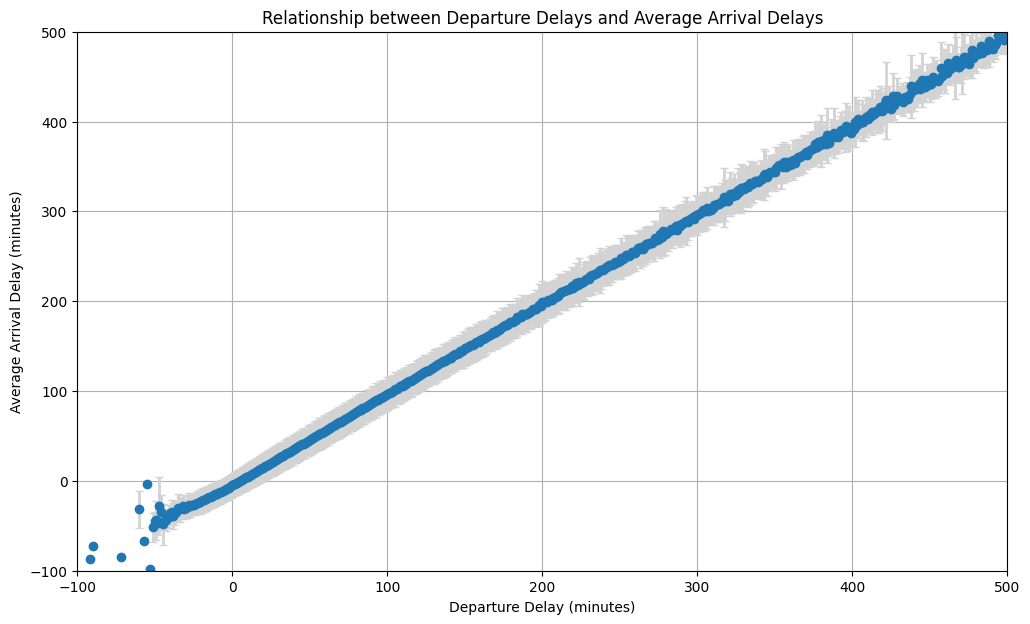

In [65]:
plt.figure(figsize=(12, 7))
plt.errorbar(
    grouped_stats['DepDelay'],
    grouped_stats['avg_arrival_delay'],
    yerr=grouped_stats['std_arrival_delay'],
    fmt='o',
    ecolor='lightgray',
    elinewidth=2,
    capsize=3
)

plt.title('Relationship between Departure Delays and Average Arrival Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.xlim(-100, 500)  # change dimensions to see better zoomed in visual
plt.ylim(-100, 500)
plt.show()

The error bars are the standard deviation on each point.

### Question 9:
For the data in Question 8, plot the percentage of arrival delay > 15 vs. departure delays. Find the departure delay, D1, at which there are more than 30% of chance the arrival delay is more than 15 minutes.  

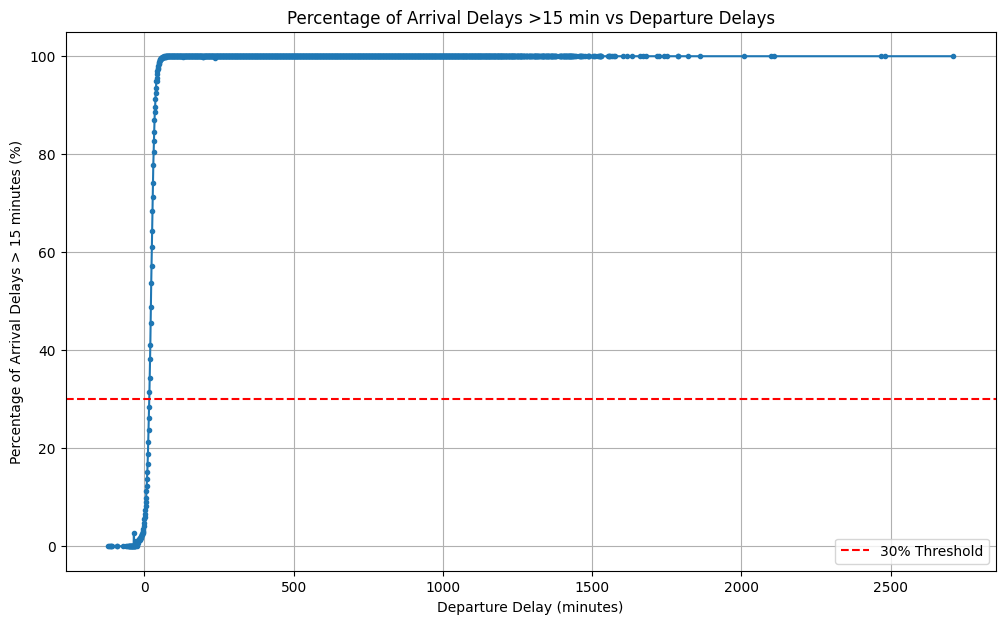

In [67]:
plt.figure(figsize=(12, 7))
plt.plot(
    grouped_stats['DepDelay'],
    grouped_stats['perc_arrival_delay_gt15'],
    marker='o',
    linestyle='-',
    markersize=3
)
plt.title('Percentage of Arrival Delays >15 min vs Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Percentage of Arrival Delays > 15 minutes (%)')
plt.grid(True)
plt.axhline(30, color='red', linestyle='--', label='30% Threshold')  # Add 30% reference line
plt.legend()
plt.show()

In [68]:
# Find D1 where chance exceeds 30%
D1_row = grouped_stats[grouped_stats['perc_arrival_delay_gt15'] > 30].sort_values('DepDelay').head(1)

D1 = D1_row['DepDelay'].values[0]

print(f"The departure delay D1 where there is more than 30% chance of arrival delay >15 minutes is: {D1} minutes")

The departure delay D1 where there is more than 30% chance of arrival delay >15 minutes is: 17.0 minutes


### Question 10: Find the decision boundary based on normal distribution assumption for 2018 data:
For each departure delay, there are at least 365 flights. Assume the arrival delays follow the normal distribution for each departure delay. For each depture delay, what is the cutoff of the arrival delay at which the probability of the arrival delays exceeding the cutoff is more than 70%?  

In [72]:
filtered_stats = grouped_stats[grouped_stats['total_count'] >= 365].copy()
from scipy.stats import norm

# Calculate the cutoff where P(ArrDelay <= cutoff) = 30%
filtered_stats['cutoff_70pct'] = norm.ppf(
    0.30,  # 30% percentile (because we want P(ArrDelay > cutoff) > 70%)
    loc=filtered_stats['avg_arrival_delay'],
    scale=filtered_stats['std_arrival_delay']
)

print(filtered_stats[['DepDelay', 'avg_arrival_delay', 'std_arrival_delay', 'cutoff_70pct']])


     DepDelay  avg_arrival_delay  std_arrival_delay  cutoff_70pct
38      -26.0         -26.833773          11.187026    -32.700255
39      -25.0         -26.536412          11.335078    -32.480533
40      -24.0         -25.549587          12.524278    -32.117325
41      -23.0         -24.217529          12.831366    -30.946304
42      -22.0         -24.094834          12.305253    -30.547715
..        ...                ...                ...           ...
295     231.0         227.739336          20.954613    216.750727
296     232.0         229.260638          20.970230    218.263839
297     233.0         229.486911          21.696029    218.109502
298     234.0         229.940092          18.808899    220.076696
300     236.0         232.965517          20.983691    221.961659

[262 rows x 4 columns]


### Question 11:
Using the data in Question 10, find the departure delay, D2, at which there is more than 70% probability that the arrival delay is more than 15 minutes

In [75]:
D2_row = filtered_stats[filtered_stats['cutoff_70pct'] <= 15].sort_values('DepDelay').head(1)

D2 = D2_row['DepDelay'].values[0]

print(f"The departure delay D2 where there is more than 70% chance that arrival delay > 15 minutes is: {D2} minutes")

The departure delay D2 where there is more than 70% chance that arrival delay > 15 minutes is: -26.0 minutes


### Question 12:
Now you have two simple models that make decision at D1 or D2. Download and ingest the data for the year 2019 to the BigQuery. Evaluate the accuracy, precision, and recall of the decision bounarires D1 and D2:
$$
accuracy = \frac{number\_of\_correctly\_predicted\_flights}{total\_number\_of\_flights}
$$

$$
precision = \frac{number\_of\_correctly\_predicted\_delayed\_flights}{total\_number\_of\_predicted\_delayed\_flights}
$$

$$
recall = \frac{number\_of\_correctly\_predicted\_delayed\_flights}{total\_number\_of\_truly\_delayed\_flights}
$$

In [77]:
D1 = 17
D2 = -26

# Query from 2019 data
query_2019 = """
SELECT
  DepDelay,
  ArrDelay
FROM
  `info323-nka42-spring2025.dsongcp.flights-2019`
WHERE
  DepDelay IS NOT NULL
  AND ArrDelay IS NOT NULL
"""
data_2019 = bq.query(query_2019).to_dataframe()

# For D1
data_2019['predicted_delayed_D1'] = data_2019['DepDelay'] > D1
data_2019['actual_delayed'] = data_2019['ArrDelay'] > 15

# Calculate confusion matrix for D1
TP_D1 = ((data_2019['predicted_delayed_D1'] == True) & (data_2019['actual_delayed'] == True)).sum()
FP_D1 = ((data_2019['predicted_delayed_D1'] == True) & (data_2019['actual_delayed'] == False)).sum()
FN_D1 = ((data_2019['predicted_delayed_D1'] == False) & (data_2019['actual_delayed'] == True)).sum()
TN_D1 = ((data_2019['predicted_delayed_D1'] == False) & (data_2019['actual_delayed'] == False)).sum()

# Metrics for D1
accuracy_D1 = (TP_D1 + TN_D1) / (TP_D1 + FP_D1 + FN_D1 + TN_D1)
precision_D1 = TP_D1 / (TP_D1 + FP_D1)
recall_D1 = TP_D1 / (TP_D1 + FN_D1)

print(f"D1 - Accuracy: {accuracy_D1:.4f}, Precision: {precision_D1:.4f}, Recall: {recall_D1:.4f}")

D1 - Accuracy: 0.9304, Precision: 0.8402, Recall: 0.7699
